# Demo 2 - Chinese Word Segmentation

The code for part 1 of this demo is taken from the tutorial mentioned in the task. It was published on huggingface.
The code for part 2 was taken from the demos 2.0 and 2.1 presented by Asad Sayeed in the course "Machine learning for NLP: advanced". The demos are about Chinese word segementation and use the conllu as well.

## Part 1 – Transformers for Sequence Classification (7 points)

Here we want to compare how Transformers work when compared to other kinds of sequence to sequence networks, such as LSTMs. Follow the tutorial [here](https://huggingface.co/docs/transformers/tasks/token_classification) in order to implement a token classification model.

The tutorial uses DistilBERT, a smaller version of BERT designed to be used when we have less memory available. BERT itself is one of the most popular Transformer models both for sequence and for token classification.

In [ ]:
pip install transformers datasets evaluate seqeval

In [ ]:
from datasets import load_dataset

#loading the WNUT 17 dataset
wnut = load_dataset("wnut_17")

#converting the numbers to their label names
label_list = wnut["train"].features[f"ner_tags"].feature.names
print(label_list)

In [ ]:
#Preprocessing

#loading a DistilBERT tokenizer to preprocess the tokens field
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
example = wnut["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(tokens)

#function to realign the tokens and labels, and truncate sequences to be no longer than DistilBERT’s maximum input length
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_wnut = wnut.map(tokenize_and_align_labels, batched=True)

#creating a batch of examples
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
#Evaluate

#gets the NER labels first, and then creates a function that passes your true predictions and true labels to compute to calculate the scores
import evaluate
import numpy as np

seqeval = evaluate.load("seqeval")

labels = [label_list[i] for i in example[f"ner_tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
#Train
#creates a map of the expected ids to their labels
id2label = {
    0: "O",
    1: "B-corporation",
    2: "I-corporation",
    3: "B-creative-work",
    4: "I-creative-work",
    5: "B-group",
    6: "I-group",
    7: "B-location",
    8: "I-location",
    9: "B-person",
    10: "I-person",
    11: "B-product",
    12: "I-product",
}
label2id = {
    "O": 0,
    "B-corporation": 1,
    "I-corporation": 2,
    "B-creative-work": 3,
    "I-creative-work": 4,
    "B-group": 5,
    "I-group": 6,
    "B-location": 7,
    "I-location": 8,
    "B-person": 9,
    "I-person": 10,
    "B-product": 11,
    "I-product": 12,
}


#setting up an optimizer function, learning rate schedule, and some training hyperparameters
from transformers import create_optimizer

batch_size = 16
num_train_epochs = 3
num_train_steps = (len(tokenized_wnut["train"]) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

#loads DistilBERT along with the number of expected labels, and the label mappings
from transformers import TFAutoModelForTokenClassification

NER_model = TFAutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=13, id2label=id2label, label2id=label2id
)

#converts your datasets to the tf.data.Dataset format
tf_train_set = NER_model.prepare_tf_dataset(
    tokenized_wnut["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = NER_model.prepare_tf_dataset(
    tokenized_wnut["validation"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

#configures the model for training
import tensorflow as tf

NER_model.compile(optimizer=optimizer)  # No loss argument!

#computes the seqeval scores from the predictions
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

#fine-tunes the model
NER_model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=3, callbacks=metric_callback)

#saves model
import os
#os.makedirs("NER_model")
NER_model.save_pretrained("NER_model")


Training worked on 2023-11-28:
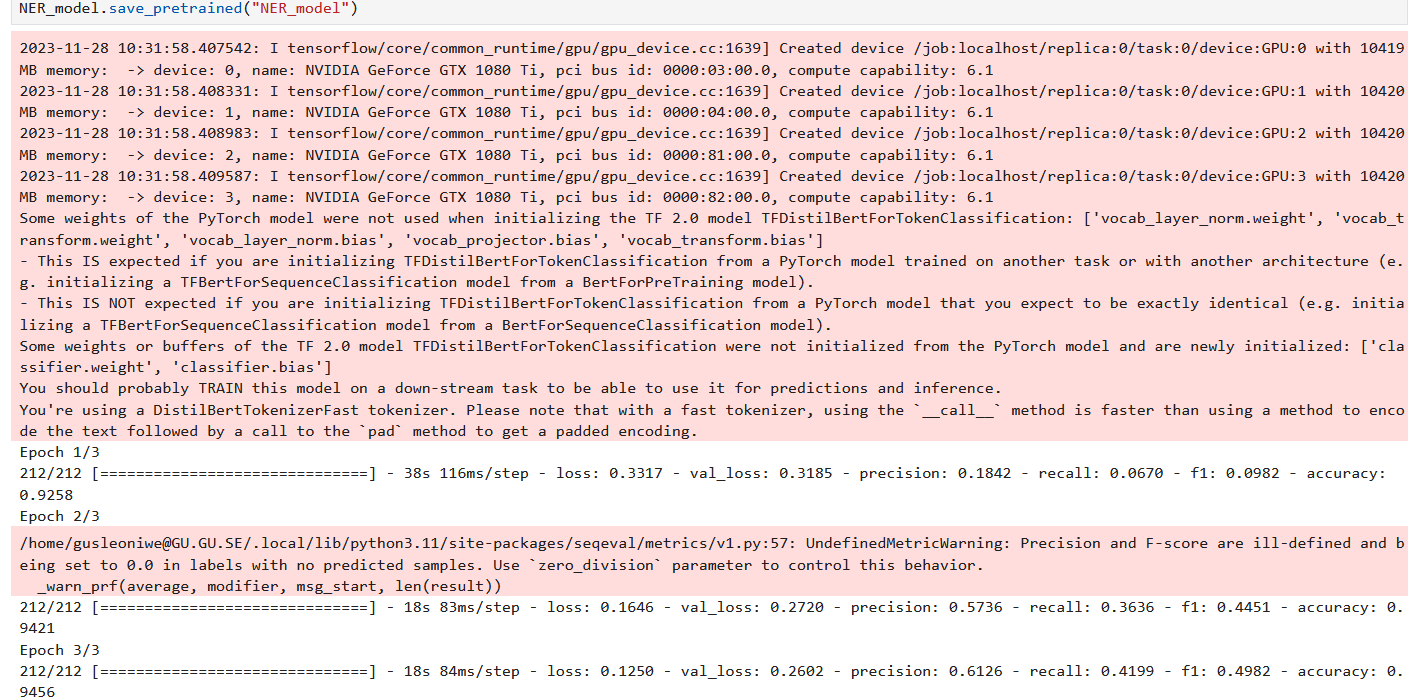

In [ ]:
import numpy as np
import tensorflow as tf
import keras

NER_model.save("./NER_model.keras")

In [ ]:
#Inference

#example text
text = "The Golden State Warriors are an American professional basketball team based in San Francisco."

#instantiates a pipeline for NER with the model, and passes the text to it
from transformers import pipeline

classifier = pipeline("ner", model="stevhliu/my_awesome_wnut_model")
classifier(text)

The results are fine but not great. The named entities are recognized but do not all have the correct labels.
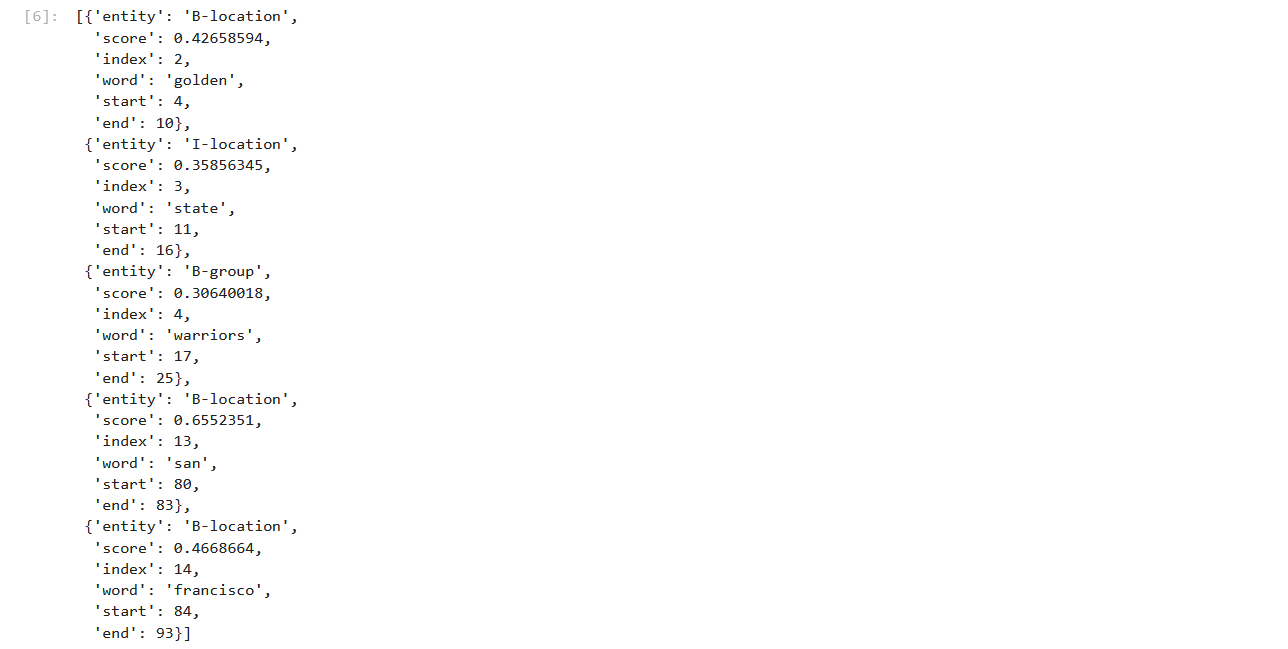

## Part 2 – Using BERT with Our Data (16 points)

The huggingface tutorial uses both an English dataset and a model pretrained in English. Change the code so that it can use the CONLL-U dataset from the demo notebook.

One of the major issues that you might find is that just changing the dataset will not yield the results we would expect. Because of that, you might also have to change the model you’re using. I wasn’t able to find a reasonably documented version of DistilBERT for Chinese, but HuggingFace has a [Chinese BERT](https://huggingface.co/bert-base-chinese') available.

Another thing to keep in mind is that BERT already segments the words as it thinks they should be segmented, so you will probably have to find a workaround in order to avoid the task being trivial (and to get a single label from each of your characters).

In [ ]:
import sys
import os
import numpy as np
import torch

In [ ]:
def read_chinese_data(inputfilename):
    with open(inputfilename, "r") as inputfile:
        sentences = []
        collection_words = []
        collection_labels = []
        for line in inputfile:
            if line[0] == '#':
                continue
            columns = line.split()
            #print(words)
            if columns == []:
                sentences.append((''.join(collection_words), collection_labels))
                collection_words = []
                collection_labels = []
                continue
            collection_words.append(columns[1])
            collection_labels += [1] + ([0] * (len(columns[1]) - 1))
            
    return sentences

In [ ]:
from torch.utils.data import Dataset, DataLoader
import datasets

class Chinese_Dataset(Dataset):
    def __init__(self, sequences, tokenizer):
        self.sequences = [x[0] for x in sequences]
        self.ner_tags = [x[1] for x in sequences]
        self.tokenizer = tokenizer

    def __len__(self):
         return len(self.sequences)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.sequences[idx], padding='max_length', truncation=True, max_length=182, return_tensors='pt')

        max_seq_length = len(encoding['input_ids'][0])
        labels = self.ner_tags[idx]
        padded_labels = labels + [0] * (max_seq_length - len(labels))

        item = {
            'tokens': self.sequences[idx],
            'input_ids': encoding['input_ids'].squeeze(0),
            'labels': padded_labels,
        }

        return item

def transform_dataset(dataset):
  data = {}
  for i in range(len(dataset)):
    item = dataset[i]
    input_ids = item["input_ids"]
    labels = item["labels"]
    data[input_ids] = labels
  format = {"input_ids" : list(data.keys()), "labels" : list(data.values())}
  dataset = datasets.Dataset.from_dict(format)
  return dataset

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
from torch.utils.data import DataLoader

train_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-train.conllu')
test_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-test.conllu')
#print(train_sentences)
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")#bert-base-chinese")

distilbert_train_dataset = Chinese_Dataset(train_sentences, distilbert_tokenizer)
train_dataloader = DataLoader(distilbert_train_dataset, batch_size = 64, shuffle= True)#train_dataset = pd.DataFrame(data=train_dataset)
distilbert_train_dataset = transform_dataset(distilbert_train_dataset)

distilbert_test_dataset = Chinese_Dataset(test_sentences, distilbert_tokenizer)
distilbert_test_dataset = transform_dataset(distilbert_test_dataset)

from transformers import DataCollatorForTokenClassification

distilbert_data_collator = DataCollatorForTokenClassification(tokenizer=distilbert_tokenizer, return_tensors="tf")


In [ ]:
#Evaluate

#gets the NER labels first, and then creates a function that passes your true predictions and true labels to compute to calculate the scores
import evaluate
import numpy as np

seqeval = evaluate.load("seqeval")

#labels = [label_list[i] for i in example[f"ner_tags"]]


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)#, labels=np.unique(true_predictions))
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
#Train
#creates a map of the expected ids to their labels
id2label = {
    0: "O",
    1: "B-corporation",
    2: "I-corporation",
    3: "B-creative-work",
    4: "I-creative-work",
    5: "B-group",
    6: "I-group",
    7: "B-location",
    8: "I-location",
    9: "B-person",
    10: "I-person",
    11: "B-product",
    12: "I-product",
}
label2id = {
    "O": 0,
    "B-corporation": 1,
    "I-corporation": 2,
    "B-creative-work": 3,
    "I-creative-work": 4,
    "B-group": 5,
    "I-group": 6,
    "B-location": 7,
    "I-location": 8,
    "B-person": 9,
    "I-person": 10,
    "B-product": 11,
    "I-product": 12,
}

#setting up an optimizer function, learning rate schedule, and some training hyperparameters
from transformers import create_optimizer

batch_size = 16
num_train_epochs = 3
num_train_steps = (len(distilbert_train_dataset) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

#loads DistilBERT along with the number of expected labels, and the label mappings
from transformers import TFAutoModelForTokenClassification

distilbertx2_model = TFAutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=13, id2label=id2label, label2id=label2id
)

#converts your datasets to the tf.data.Dataset format
distilbert_tf_train_set = distilbertx2_model.prepare_tf_dataset(
    distilbert_train_dataset,
    shuffle=True,
    batch_size=16,
    collate_fn=distilbert_data_collator,
)

distilbert_tf_validation_set = distilbertx2_model.prepare_tf_dataset(
    distilbert_test_dataset,
    shuffle=False,
    batch_size=16,
    collate_fn=distilbert_data_collator,
)

#configures the model for training
import tensorflow as tf

distilbertx2_model.compile(optimizer=optimizer)  # No loss argument!

#computes the seqeval scores from the predictions
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=distilbert_tf_validation_set)

#fine-tunes the model
distilbertx2_model.fit(x=distilbert_tf_train_set, validation_data=distilbert_tf_validation_set, epochs=3, callbacks=metric_callback)

#saves model
import os
#os.makedirs("distilbertx2_model")
distilbertx2_model.save_pretrained("distilbertx2_model")

Training worked on 2023-11-28:
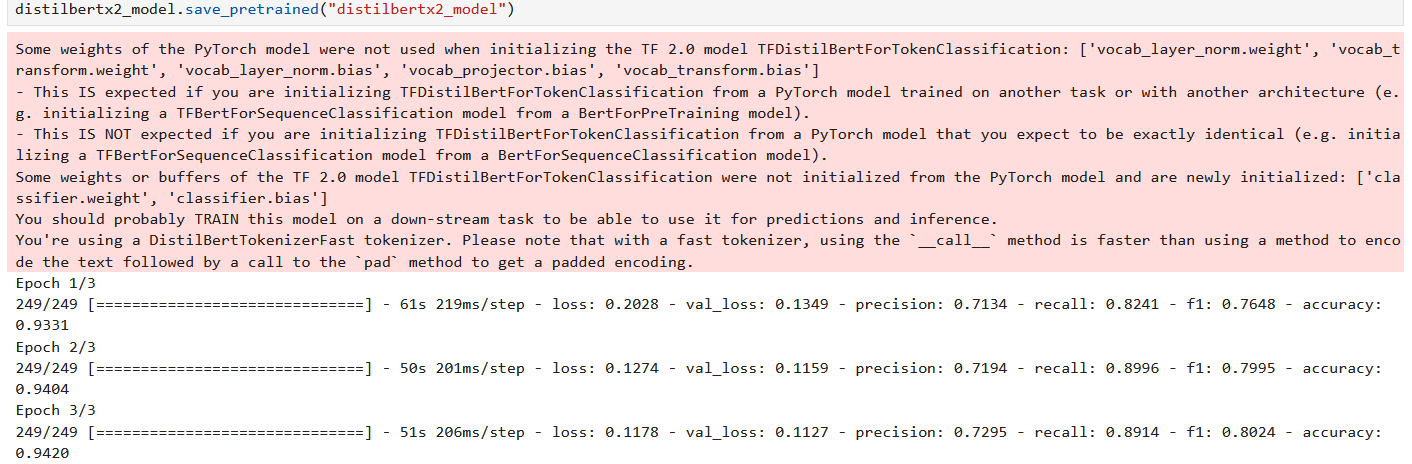

## Bert-base Chinese Tokenizer
In the following I used the tokenizer especially for Chinese data.

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import pandas as pd
from torch.utils.data import DataLoader

train_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-train.conllu')
test_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-test.conllu')
#print(train_sentences)
chineseBert_tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

chineseBert_train_dataset = Chinese_Dataset(train_sentences, chineseBert_tokenizer)
train_dataloader = DataLoader(chineseBert_train_dataset, batch_size = 64, shuffle= True)
chineseBert_train_dataset = transform_dataset(chineseBert_train_dataset)

chineseBert_test_dataset = Chinese_Dataset(test_sentences, chineseBert_tokenizer)
chineseBert_test_dataset = transform_dataset(chineseBert_test_dataset)

from transformers import DataCollatorForTokenClassification

chineseBert_data_collator = DataCollatorForTokenClassification(tokenizer=chineseBert_tokenizer, return_tensors="tf")


In [ ]:
#Train

from transformers import create_optimizer

batch_size = 16
num_train_epochs = 3
num_train_steps = (len(chineseBert_train_dataset) // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

#loads DistilBERT along with the number of expected labels, and the label mappings
from transformers import TFAutoModelForTokenClassification

distilbert_model = TFAutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=13, id2label=id2label, label2id=label2id
)

#converts your datasets to the tf.data.Dataset format
chineseBert_tf_train_set = distilbert_model.prepare_tf_dataset(
    chineseBert_train_dataset,
    shuffle=True,
    batch_size=16,
    collate_fn=chineseBert_data_collator,
)

chineseBert_tf_validation_set = distilbert_model.prepare_tf_dataset(
    chineseBert_test_dataset,
    shuffle=False,
    batch_size=16,
    collate_fn=chineseBert_data_collator,
)

#configures the model for training
import tensorflow as tf

distilbert_model.compile(optimizer=optimizer)  # No loss argument!

#computes the seqeval scores from the predictions
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=chineseBert_tf_validation_set)

#fine-tunes the model
distilbert_model.fit(x=chineseBert_tf_train_set, validation_data=chineseBert_tf_validation_set, epochs=3, callbacks=metric_callback)

#saves model
import os
#os.makedirs("distilbert,chineseBert_model")
distilbert_model.save_pretrained("distilbert,chineseBert_model")

Training worked on 2023-11-28:
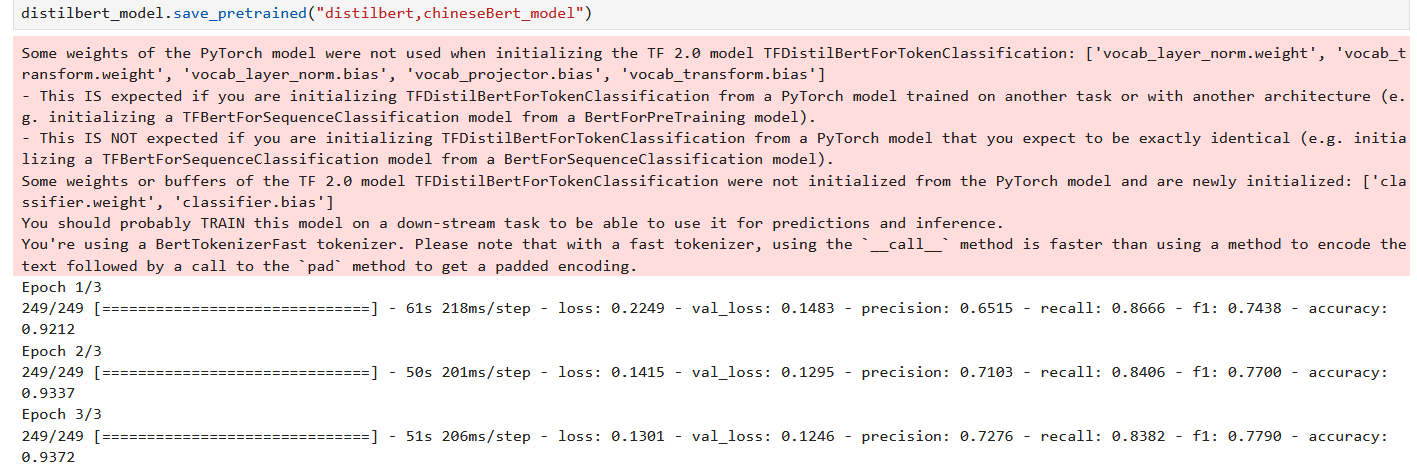

In [ ]:
import numpy as np
import tensorflow as tf
import keras

distilbert_model.save("./NER_model.keras")

## Change to Chinese Bert Model

In [ ]:
#creates a map of the expected ids to their labels
id2label = {
    0: "O",
    1: "B-corporation",
    2: "I-corporation",
    3: "B-creative-work",
    4: "I-creative-work",
    5: "B-group",
    6: "I-group",
    7: "B-location",
    8: "I-location",
    9: "B-person",
    10: "I-person",
    11: "B-product",
    12: "I-product",
}
label2id = {
    "O": 0,
    "B-corporation": 1,
    "I-corporation": 2,
    "B-creative-work": 3,
    "I-creative-work": 4,
    "B-group": 5,
    "I-group": 6,
    "B-location": 7,
    "I-location": 8,
    "B-person": 9,
    "I-person": 10,
    "B-product": 11,
    "I-product": 12,
}

#Train
chineseBert_model = TFAutoModelForTokenClassification.from_pretrained(
    "bert-base-chinese", num_labels=13, id2label=id2label, label2id=label2id
)

#converts your datasets to the tf.data.Dataset format
chineseBertx2_tf_train_set = chineseBert_model.prepare_tf_dataset(
    chineseBert_train_dataset,
    shuffle=True,
    batch_size=16,
    collate_fn=chineseBert_data_collator,
)

chineseBertx2_tf_validation_set = chineseBert_model.prepare_tf_dataset(
    chineseBert_test_dataset,
    shuffle=False,
    batch_size=16,
    collate_fn=chineseBert_data_collator,
)

chineseBert_model.compile(optimizer=optimizer) 
chineseBert_model.fit(x=chineseBertx2_tf_train_set, validation_data=chineseBertx2_tf_validation_set, epochs=3, callbacks=metric_callback)

#saves model
import os
#os.makedirs("chineseBert_model")
chineseBert_model.save_pretrained("chineseBert_model")

Training worked on 2023-11-28: (without own train and validation set)
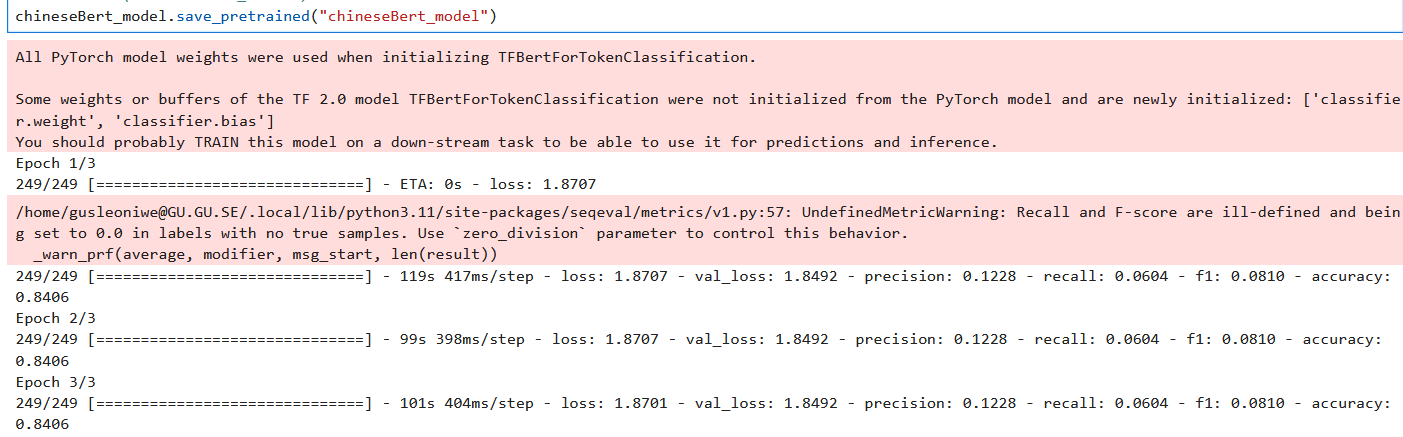
with own train and validation set the results are way worse! there seems to be somehting wrong with the segmentation in this case. Maybe this uses characters as warned about in the task description. I have to look at an example in part 3.
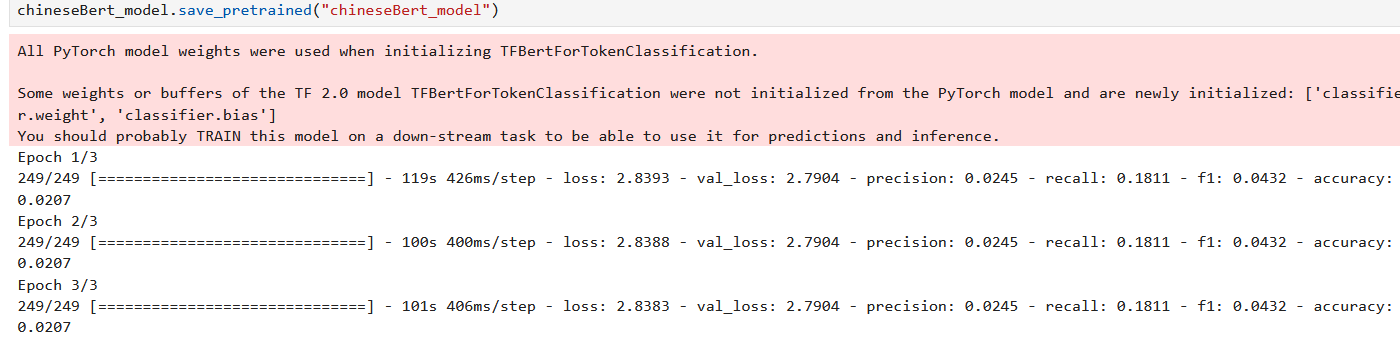

## Chinese Word Segmentation using LSTM 
The code from this part is taken from the demo 2.1 "Chinese Word Segmentation - LSTM".

In [ ]:
train_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-train.conllu')
test_sentences = read_chinese_data('/scratch/lt2316-h20-resources/zh_gsd-ud-test.conllu')

def index_chars(sentences):
    megasentence = ''.join(sentences)
    char_list = set()
    for c in megasentence:
        char_list.add(c)
    char_list = [0] + list(char_list)
    return char_list, {char_list[x]:x for x in range(len(char_list))}

int_index, char_index = index_chars([x[0] for x in train_sentences + test_sentences])

In [ ]:
def convert_sentence(sentence, index):
    return [index[x] for x in sentence]

In [ ]:
def pad_lengths(sentences, max_length, padding=0):
    return [x + ([padding] * (max_length - len(x))) for x in sentences]

In [ ]:
def create_dataset(x, device="cpu"):
    converted = [(convert_sentence(x1[0], char_index), x1[1]) for x1 in x]
    X, y = zip(*converted)
    lengths = [len(x2) for x2 in X]
    padded_X = pad_lengths(X, max(lengths))
    Xt = torch.LongTensor(padded_X).to(device)
    padded_y = pad_lengths(y, max(lengths), padding=-1)
    yt = torch.LongTensor(padded_y).to(device)
    lengths_t = torch.LongTensor(lengths).to(device)
    return Xt, lengths_t, yt

In [ ]:
train_X_tensor, train_lengths_tensor, train_y_tensor = create_dataset(train_sentences, "cuda:2")
test_X_tensor, test_lengths_tensor, test_y_tensor = create_dataset(test_sentences, "cuda:2")

In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

testtensor = torch.randn((10,100,200))
testlengths = torch.randint(1, 100, (10,))
packed = pack_padded_sequence(testtensor, testlengths, batch_first=True, enforce_sorted=False)
unpacked = pad_packed_sequence(packed, batch_first=True, total_length=100)

In [ ]:
class Batcher:
    def __init__(self, X, lengths, y, device, batch_size=50, max_iter=None):
        self.X = X
        self.lengths = lengths # We need the lengths to efficiently use the padding.
        self.y = y
        self.device = device
        self.batch_size=batch_size
        self.max_iter = max_iter
        self.curr_iter = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.curr_iter == self.max_iter:
            raise StopIteration
        permutation = torch.randperm(self.X.size()[0], device=self.device)
        permX = self.X[permutation]
        permlengths = self.lengths[permutation]
        permy = self.y[permutation]
        splitX = torch.split(permX, self.batch_size)
        splitlengths = torch.split(permlengths, self.batch_size)
        splity = torch.split(permy, self.batch_size)
        
        self.curr_iter += 1
        return zip(splitX, splitlengths, splity)

In [ ]:
b = Batcher(train_X_tensor, train_lengths_tensor, train_y_tensor, torch.device('cuda:2'), max_iter=100)

In [ ]:
import torch.nn as nn

nllloss = nn.NLLLoss(ignore_index=-1).to("cuda:2")

class Segmenter(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        
        self.emb = nn.Embedding(self.vocab_size, self.emb_size, 0)
        self.lstm = nn.LSTM(self.emb_size, 150, batch_first=True)
        self.sig1 = nn.Sigmoid()
        self.lin = nn.Linear(150, 2)
        self.softmax = nn.LogSoftmax(2)
        
    def forward(self, x, lengths):
        embs = self.emb(x)
        packed = pack_padded_sequence(embs, lengths.to("cpu"), batch_first=True, enforce_sorted=False)
        output1, _ = self.lstm(packed)
        unpacked, _ = pad_packed_sequence(output1, batch_first=True)
        output2 = self.sig1(unpacked)
        output3 = self.lin(output2)
        return self.softmax(output3)


import torch.optim as optim

def train(X, lengths, y, vocab_size, emb_size, batch_size, epochs, device, model=None):
    b = Batcher(X, lengths, y, device, batch_size=batch_size, max_iter=epochs)
    if not model:
        m = Segmenter(vocab_size, emb_size).to(device)
    else:
        m = model
    loss = nn.NLLLoss(ignore_index=-1)
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch = 0
    for split in b:
        tot_loss = 0
        for batch in split:
            optimizer.zero_grad()
            o = m(batch[0], batch[1])
            l = loss(o.permute(0,2,1), batch[2][:, :max(batch[1])])
            tot_loss += l
            l.backward()
            optimizer.step()
        print("Total loss in epoch {} is {}.".format(epoch, tot_loss))
        epoch += 1
    return m

CNN_model = train(train_X_tensor, train_lengths_tensor, train_y_tensor, len(int_index), 200, 50, 30, "cuda:2")

#os.makedirs("CNN_model")
#CNN_model.save_pretrained("CNN_model")
#CNN_model.save("CNN_model.h5", include_optimizer=True)

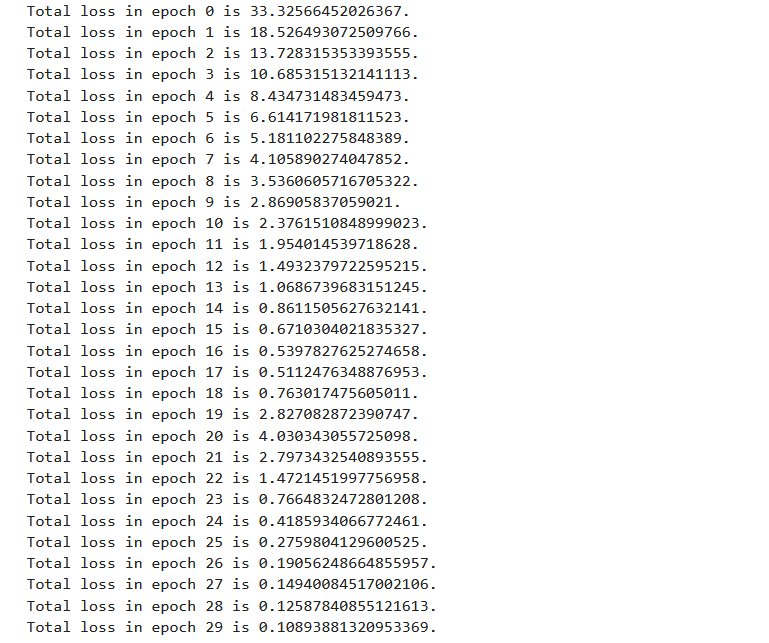

In [ ]:
# Evaluation
#CNN_model.save_pretrained("CNN_model")
torch.save(CNN_model.state_dict(), "CNN_model") #this saves something but it doesn't look like the others with a config file etc. ..

In [ ]:
import math

CNN_model.eval()

with torch.no_grad():
    rawpredictions =CNN_model(test_X_tensor, test_lengths_tensor)

predictions = torch.argmax(rawpredictions, 2)

test_sentences[0]

collectpreds = []
collecty = []

for i in range(test_X_tensor.size(0)):
    collectpreds.append(predictions[i][:test_lengths_tensor[i]])
    collecty.append(test_y_tensor[i][:test_lengths_tensor[i]])

allpreds = torch.cat(collectpreds)

classes = torch.cat(collecty)

classes = classes.float()
allpreds = allpreds.float()

tp = sum(classes * allpreds)
fp = sum(classes * (~allpreds.bool()).float())
tn = sum((~classes.bool()).float() * (~allpreds.bool()).float())
fn = sum((~classes.bool()).float() * allpreds)
accuracy = (tp + tn) / (tp + fp + tn + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = (2 * recall * precision) / (recall + precision)

print("Precision: ")
print(precision)
print("Recall: ")
print(recall)
print("Accuracy: ")
print(accuracy)
print("F1-score: ")
print(f1)

## Part 3 – Performance Analysis (7 points)

Do a comparison between both models and how differently they perform. We are assuming that most of you don’t read Chinese, so we are not expecting much in the area of qualitative analysis.
Most of the code is taken from the tutorial again. All of the following code cells throw errors.

In [ ]:
chinese_text = test_sentences[0]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("NER_model_try")
inputs = tokenizer(chinese_text, return_tensors="tf")

from transformers import AutoModelForTokenClassification

model = TFAutoModelForTokenClassification.from_pretrained("NER_model_try")
logits = model(**inputs).logits

predicted_token_class_ids = tf.math.argmax(logits, axis=-1)
predicted_token_class = [model.config.id2label[t] for t in predicted_token_class_ids[0].numpy().tolist()]
predicted_token_class

## Testing distilbertx2 model
This does not work so far but here you can see how I tried. SInce this didn't work, I did not include code for the other models.

In [ ]:
chinese_text = test_sentences[0]

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("stevhliu/my_awesome_wnut_model")
inputs = tokenizer(chinese_text, return_tensors="tf")

from transformers import TFAutoModelForTokenClassification

model = distilbertx2_model
logits = model(**inputs).logits

predicted_token_class_ids = tf.math.argmax(logits, axis=-1)
predicted_token_class = [model.config.id2label[t] for t in predicted_token_class_ids[0].numpy().tolist()]
predicted_token_class

In [ ]:
#Inference

#example text
chinese_text = test_sentences[0]
predicted_classes = np.argmax(NER_model.predict(chinese_text),axis=1)

for i in range(len(chinese_text)):
 print("X=%s, Predicted=%s" % (chinese_text[i], predicted_classes[i]))

Looking at the accuracy, precision and recall values so far, we can see that the 
CNN model has the highest precision and recall and, therefore, highest f1 score, which means it is the most balanced of them all. The highest accuracy can be achieved using the model used in the tutorial on huggingface. However, the values of the chineseBert model imply that there is probably something worng with the segmentation process in this case.

distilbertx2_model: precision: 0.7251 - recall: 0.8914 - f1: 0.7997 - accuracy: 0.9411

distilbert,chineseBert_model: precision: 0.7424 - recall: 0.8120 - f1: 0.7757 - accuracy: 0.9380

chineseBert_model: precision: 0.2298 - recall: 0.4021 - f1: 0.2925 - accuracy: 0.0545

CNN_model: precision: 0.9422 - recall: 0.9396 - f1: 0.9409 - accuracy: 0.9260